# Representing Diverse Data

In this notebook, we will take a whirlwind tour of different representations of text, image, audio, and network data. Representations lie at the core of deep learning, and to understand how deep learning creates them we must first understand what kind of popular representations already exist for different data types, what a representation is expected to capture, and what it can actually capture. 

We will go from text data to image data to audio data to network data, briefly discussing how to make measurement within and even between some of these representations. 

Another focus of this notebook is how to adapt a wide variety of python packages to create data representations - there is rarely one package which fits all your purposes and being able to search for and draw from among the large number available is a valuable skill. Usually, our end goal is to go from $[\text{social object}] \rightarrow [\text{high dimensional vector/tensor}]$.

NOTE: this notebook longer than those past, as we tour through so many different forms of data and their representations. While you are encouraged to closely examine each cell and experiment, in the interest of time, we encourage you to look at the homework assignment, then come back and focus on parts of the notebook you will best need to know to complete that homework. The second tutorial for this week is *much shorter* to compensate for it!

Alright, let's go! 


## Text Data : Cleaning, Organising, and Representing

This section will cover basic code and key concepts for textual data cleaning, organising and representing. We often describe this part of dealing with data as pre-processing. We also note that it is often encouraged to perform less pre-processing with deep learning methods and more data (e.g., stem with small data and non-neural methods; do not stem with big data and neural methods.) At the limits, with extremely large data and very deep models, we may actually add noise to the data to increase the robustness of our models to errors and outliers.

In [2]:
!pip install -U yellowbrick

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# text related packages
import gensim
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [5]:
# ML and DL packages
import sklearn
import keras

In [6]:
# no critical warnings, so we supress it
import warnings
warnings.simplefilter("ignore")

Let's whip up some trivial texts so that we can illustrate the creation of different representations. We will construct our raw texts such that there are a few overlapping words. Note that there are 4 sentences, and each sentence is the complete document or text.

In [7]:
raw_texts = ["Apples taste like onions when we cannot smell.",
             "I find it easy to compare apples and oranges.",
             "Chopping onions can make you cry.",
             "Peeling an orange does not make you cry."]

We now load an English [spaCy language model](https://spacy.io/usage/models), which allows us to do a number of basic linguistic and textual analysis.

In [8]:
nlp = spacy.load('en_core_web_sm')

Our first use of the language model is to clean the data - when we pass text through the language model, it [tokenises](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) it, and assigns various attributes, such as whether or not it is a [stop word](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), number, and its part of speech. A stop word is a word we deem irrelevant or will distract from or diminish our analysis - some examples are articles (a, an, the), filler words, and so on. You will notice that here we also used a [lemmatised](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) form of the word, which is a way of extracting the linguistic 'root' of the word. Again, the more plentiful your data and deeper your model (e.g., BERT), the less likely you should be to remove, prune and process text data because the model is designed to do it for you. Even then, however, sometimes augmenting data with these representations can accelerate model training and performance. 

In [9]:
texts, article = [], []
for text in raw_texts:
    doc = nlp(text)
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)

    texts.append(article)


Let's see what that did to our texts.

In [10]:
texts

[['apple', 'taste', 'like', 'onion', 'smell'],
 ['find', 'easy', 'compare', 'apple', 'orange'],
 ['chop', 'onion', 'cry'],
 ['peel', 'orange', 'cry']]

We see that from a list of strings we now have a list of lists, and each of these lists is a list of strings (words, or tokens). You can see that punctuation and stop words are removed and it is now closer to machine-readable and analysis-ready. This process of going from raw, punctuated text to individual tokens is called tokenization.

Now, we use the gensim dictionary class to map each of these words to an ID and represent them as a bag of words.

In [11]:
dictionary = Dictionary(texts)

In [12]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(0, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(2, 1), (9, 1), (10, 1)],
 [(8, 1), (10, 1), (11, 1)]]

We see here that each sentence is represented by a word ID and the number of times it was present in that document. We now look at Term Frequency - Inverse Document Frequency ([TF-IDF](https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)), one simple way to measure word importance (locally and globally). Such representations begin to build representations that begin to approximate some of the things automatically learned within a deep model. Sometimes these representations can be fed into a deep model as input (augmented data).

In [14]:
from gensim.models import TfidfModel


In [15]:
tf_idf_model = TfidfModel(corpus)

In [16]:
tf_idf_texts = tf_idf_model[corpus]

In [17]:
tf_idf_texts[0]

[(0, 0.2672612419124244),
 (1, 0.5345224838248488),
 (2, 0.2672612419124244),
 (3, 0.5345224838248488),
 (4, 0.5345224838248488)]

In [18]:
tf_idf_texts[1]

[(0, 0.2672612419124244),
 (5, 0.5345224838248488),
 (6, 0.5345224838248488),
 (7, 0.5345224838248488),
 (8, 0.2672612419124244)]

We now see each document is a word ID mapped to a number that measures how it distinguishes the document.

### One Hot Encoding and Vectorising with scikit-learn

So we saw how we can go from raw, punctuated texts to cleaner texts my manually picking out what we want. The bag of words format tells us which words exist, but the vector length isn't standard, and you can see the same for TF-IDF. There are ways to present this information in what is called a 1-hot vector, where the length of the vector is the whole vocabulary. 

It can be useful to use gensim and spaCy for pre-processing because it is more clear at each step what my data structure looks like. However, for an abstracted approach to text pre-processing, scikit-learn works well, especially when you want to feed it into a traditional machine learning algorithm. Gensim, for example, would convert bag of words or tf-idf into a similar data structure under the hood to keep the lengths of the vector the same. 

See below for code to use the scikit-learn vectoriser, which creates both one hot encoding vectors as well as tf-idf vectors which are **sparse representations**. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [20]:
vectorizer = CountVectorizer()

In [21]:
X = vectorizer.fit_transform(raw_texts).toarray()

In [22]:
vectorizer.vocabulary_

{'apples': 2,
 'taste': 20,
 'like': 12,
 'onions': 15,
 'when': 23,
 'we': 22,
 'cannot': 4,
 'smell': 19,
 'find': 10,
 'it': 11,
 'easy': 9,
 'to': 21,
 'compare': 6,
 'and': 1,
 'oranges': 17,
 'chopping': 5,
 'can': 3,
 'make': 13,
 'you': 24,
 'cry': 7,
 'peeling': 18,
 'an': 0,
 'orange': 16,
 'does': 8,
 'not': 14}

In [23]:
raw_texts

['Apples taste like onions when we cannot smell.',
 'I find it easy to compare apples and oranges.',
 'Chopping onions can make you cry.',
 'Peeling an orange does not make you cry.']

In [24]:
len(X[0]), len(vectorizer.vocabulary_)

(25, 25)

You can see that the length of each vector is the length of the full vocavulary. Below, for each document, a 1 is a presence of that word_id (which you can confirm using the dictionary above), and a 0 is the absence of a word. 

In [25]:
print(X)

[[0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0]
 [0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1]]


Below this we create a similar sparse representation, but using TF-IDF, and remove stop-words using the built-in function.

In [26]:
vectorizer = TfidfVectorizer(stop_words='english')

In [27]:
X = vectorizer.fit_transform(raw_texts).toarray()

In [28]:
print(X)

[[0.38274272 0.         0.         0.         0.         0.48546061
  0.         0.38274272 0.         0.         0.         0.48546061
  0.48546061]
 [0.41428875 0.         0.52547275 0.         0.52547275 0.
  0.         0.         0.         0.52547275 0.         0.
  0.        ]
 [0.         0.66767854 0.         0.         0.         0.
  0.52640543 0.52640543 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.52547275 0.         0.
  0.41428875 0.         0.52547275 0.         0.52547275 0.
  0.        ]]


We will now be moving on from sparse representations to dense representations of documents, with a range of methods which can be used to condense information in a body of text.

### Low and High Dimensional Representations of Text and Documents

One of the issues with using a bag of words or TF-IDF to represent documents is that even though you’ve reduced the size of the document from the full vocabulary, for documents with a lot of words, they remain very high dimensional objects (e.g., where each dimension is defined by a word in the vocabulary, a long document might have 20,000 dimensions or unique words). LSA stands for latent semantic analysis (sometimes also referred to as LSI, or Latent Semantic Indexing), and is a way to represent text documents by reducing the dimensionality of the word (or meaning)-space represented by a TF-IDF or bag of words. The idea is this: if words in documents are rows and the documents are columns, we want to keep the same distance between columns (documents) while reducing the number of rows (reduced word-features). By representing documents with a reduced number of features instead of using all the words, we now represent each with “latent” features rooted in the idea of distributional semantics--that words appearing together are likely to reference similar meanings.

Let us use TruncatedSVD to perform a latent semantic analysis on our data. SVD -- Singular Value Decomposition -- is a form of matrix factorization very similar to Principle Components Analysis (PCA), which we saw last week, but it can be computed on rectangular (not square) datasets. The truncation comes as we limit the number of Singular Values (dimensions) that we consider by selecting the most informative and distinguishing $n$. 

In [29]:
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [30]:
X = lsa.fit_transform(X)

In [31]:
X

array([[ 0.80128627,  0.59828114],
       [ 0.41506543,  0.90979156],
       [ 0.93368336, -0.35809968],
       [ 0.66405657, -0.74768233]])

Each document here is represented by 2 features ($n=2$)!

Now we'll take a quick peak at topic models, word and document embedding methods, and other low dimensional methods that can be used to represent document in meaning space. 

We're going to use a bigger dataset, because these methods are only useful when we have substantial data. Models based on very large datasets take time to train, so we'll use a medium sized corpus that comes pre-loaded with gensim to illustare the concepts.

In [32]:
import os

In [33]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [34]:
doc = nlp(text.lower())

In [35]:
my_stop_words = [u'say', u'mr', u'said', u'saying', u'says']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [36]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I':
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [37]:
len(texts)

299

In [38]:
texts[0][0:10]

['hundred',
 'people',
 'force',
 'vacate',
 'home',
 'southern',
 'highland',
 'new',
 'south',
 'wale']

### Bi-grams and n-grams
Here we identify statistically significant bigrams (two sequential word units of meaning) that may go into a model as single units.

In [39]:
bigram = gensim.models.Phrases(texts)

In [40]:
texts = [bigram[line] for line in texts]

In [41]:
texts[0][0:20]

['hundred',
 'people',
 'force',
 'vacate',
 'home',
 'southern',
 'highland',
 'new_south',
 'wale',
 'strong',
 'wind',
 'today',
 'push',
 'huge',
 'bushfire',
 'town',
 'hill',
 'new',
 'blaze',
 'near']

### Topic Models
Topic models are a two-level clustering technique in which topics are identified as distributions over words, such that documents may be modeled as distributions over topics. 

In [42]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [43]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [44]:
ldamodel.print_topics()

[(0,
  '0.005*"australia" + 0.005*"people" + 0.005*"afghanistan" + 0.004*"australian" + 0.004*"force" + 0.004*"new" + 0.004*"claim" + 0.004*"man" + 0.004*"al_qaeda" + 0.004*"attack"'),
 (1,
  '0.005*"australian" + 0.005*"force" + 0.004*"australia" + 0.004*"test" + 0.004*"police" + 0.004*"day" + 0.003*"palestinian" + 0.003*"government" + 0.003*"official" + 0.003*"israeli"'),
 (2,
  '0.006*"australian" + 0.006*"union" + 0.004*"day" + 0.004*"australia" + 0.003*"year" + 0.003*"company" + 0.003*"today" + 0.003*"people" + 0.003*"police" + 0.003*"month"'),
 (3,
  '0.005*"australian" + 0.005*"government" + 0.004*"company" + 0.004*"year" + 0.004*"time" + 0.004*"arafat" + 0.003*"tell" + 0.003*"israeli" + 0.003*"australia" + 0.003*"come"'),
 (4,
  '0.007*"people" + 0.005*"australia" + 0.005*"report" + 0.005*"year" + 0.005*"australian" + 0.004*"day" + 0.004*"kill" + 0.004*"government" + 0.003*"attack" + 0.003*"force"')]

In [45]:
lda_doc_5 = ldamodel[dictionary.doc2bow(texts[5])]

In [46]:
lda_doc_5

[(0, 0.99019164)]

In [47]:
texts[5][0:15]

['federal_government',
 'safe',
 'afghani',
 'asylum_seeker',
 'australia',
 'return',
 'home',
 'environment',
 'secure',
 'government',
 'suspend',
 'application',
 'interim_government',
 'establish',
 'kabul']

The document on Australian government and asylum is recognized as being composed of a topic with the top words of "Australia", "government", and "people". Now we've seen how both LDA and LSI, in two different packages, and a variety of ways to represent textual documents. Some representations of textual documents can be especially useful for visualising documents - let's try a few of these.

### Dimensionality Reduction for Document Visualisation

Some methods are built with visualisation in mind, and t-SNE and UMAP are two of them. These are more striking when we have labels descriptive of higher-level category, so we will be using a pre-loaded dataset from the Yellowbricks package.

In [48]:
!pip install umap-learn

In [49]:
from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies
from yellowbrick.text import UMAPVisualizer

In [50]:
# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer()

In [51]:
X = tfidf.fit_transform(corpus.data)
y = corpus.target


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

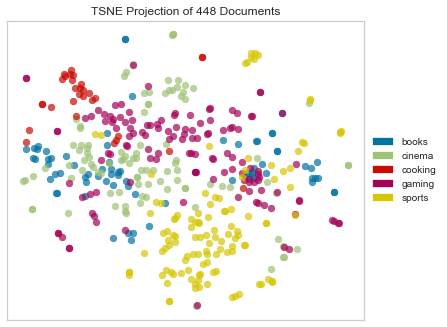

<AxesSubplot:title={'center':'TSNE Projection of 448 Documents'}>

In [52]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

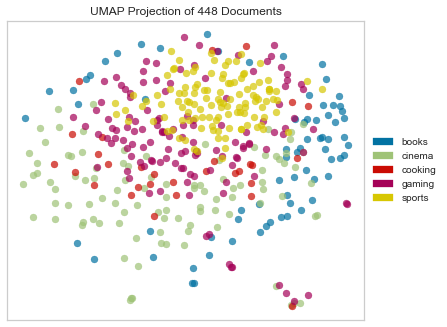

<AxesSubplot:title={'center':'UMAP Projection of 448 Documents'}>

In [53]:
# Instantiate the text visualizer
umap = UMAPVisualizer()
umap.fit(X, y)
umap.show()

### Embedding Models - High Dimensional Representations

Also inspired by notions of distributional semantics, word embedding representations are learned through neural network methods such as word2vec and GloVe. When we task a neural network with predicting word or sentence context, it learns useful representations of words to perform these tasks. Such representations are then repurposed to represent words in a semantic space guided by distributional semantics over documents. These high dimensional representations of words are still lower dimensional representations than words in a document, similar to LSA, Topic Modelling and other approaches to matrix factorisation. 

We will explore word (and other) embeddings in more detail in later exercises and chapters.


In [54]:
from gensim.models import Word2Vec


In [55]:
w2vmodel = Word2Vec(
        texts,
        vector_size=100,
        window=10,
        workers=10,
        epochs=10)

In [56]:
w2vmodel.wv.most_similar("war")

[('hold', 0.9996781945228577),
 ('tell', 0.9996218681335449),
 ('include', 0.9996152520179749),
 ('international', 0.9996141195297241),
 ('continue', 0.9996122717857361),
 (' ', 0.9996077418327332),
 ('carry', 0.999606192111969),
 ('try', 0.999605119228363),
 ('return', 0.9995957016944885),
 ('call', 0.9995761513710022)]

In [57]:
w2vmodel.wv["war"]

array([-1.93510190e-01,  7.01581061e-01, -2.30248049e-02, -1.34395078e-01,
        1.68576300e-01, -7.58070886e-01,  2.58048743e-01,  8.09844792e-01,
       -2.99468875e-01, -6.27250120e-04, -4.21961516e-01, -4.76846844e-01,
       -1.93625957e-01,  5.68097532e-02,  4.48799282e-01, -4.53501433e-01,
        1.02540918e-01, -4.86699194e-01,  2.10510746e-01, -7.17952847e-01,
        2.68368214e-01,  4.07282189e-02,  5.05834073e-03,  1.46509102e-02,
       -7.08607212e-02, -5.24563268e-02, -3.96588504e-01, -5.46988070e-01,
       -1.22812279e-01,  1.65221527e-01,  2.42186561e-01, -1.16037577e-02,
        1.77460521e-01, -1.59788325e-01, -5.86434873e-03,  6.13285482e-01,
       -1.36633158e-01, -4.91443366e-01, -2.95030206e-01, -1.07550585e+00,
       -1.17496930e-01, -3.66113096e-01,  2.29258269e-01,  3.21133658e-02,
        1.71711221e-01, -2.43820041e-01, -1.09914176e-01, -2.15848625e-01,
        9.78590995e-02,  3.20258051e-01,  2.87784070e-01, -3.20566207e-01,
       -1.75017148e-01,  

We don't always have to train our own models. One of the advantages of word embedding (and many deep learning) models is using pre-trained models, where the training has already been completed in a large and/or representative corpus or document collection. In the following lines of code we load either a [Google News model](https://drive.google.com/file/d/1TW3h1SIx__4Y6zEzLnrPry2Z-6BZgtyh/view?usp=sharing) (3+ GB), or a [model trained on NY Times data](https://drive.google.com/file/d/1xrs1UhTH5LPTBFLcflX-nQ86zwCAoLt5/view?usp=sharing) (30 MB). If you have Colab Pro, you can try the heavier model. I have used the mounting capacity on google drive here. You can also just upload the file if you would like.

### If using Drive (Colab):

In [58]:
# from google.colab import drive
# drive.mount('/content/drive')
# model_address = "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin" 

### If using local machine:

In [59]:
 model_address = "content/nytimes_cbow.reduced.txt"

In [60]:
nytimes_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address)

In [61]:
nytimes_w2v_model.most_similar("war")

[('war,', 0.7635127902030945),
 ('war.', 0.7409633994102478),
 ('wars', 0.6948893666267395),
 ('conflict', 0.6237268447875977),
 ('Iraq', 0.560003936290741),
 ('insurgency', 0.5480648875236511),
 ('fighting', 0.5464019775390625),
 ('invasion', 0.5300629138946533),
 ('conflict,', 0.5284298062324524),
 ('battle', 0.515427827835083)]

In [62]:
nytimes_w2v_model["war"]

array([-1.956257,  1.188616,  1.468125,  1.015812,  1.485821,  0.356192,
       -1.10297 , -0.583099,  3.389345,  1.015749,  0.386775, -0.678939,
        2.303188,  1.876737,  1.978349, -0.243041, -0.387137, -0.40122 ,
       -1.369221, -0.940457,  0.946169, -0.257243, -0.721836, -1.117588,
       -0.138289, -1.041047, -0.775718,  0.965613, -1.3655  , -0.257179,
       -0.502365,  0.606767, -0.085418, -0.632137,  0.252721,  0.376596,
        2.444461,  0.255977,  0.469996, -0.355164, -1.135481,  0.056103,
        0.365298, -1.682217,  0.124393,  0.144604,  0.052531, -0.514495,
       -0.961651,  1.294883, -0.181481,  0.506228, -0.297303, -0.401765,
        0.031583, -0.009966,  0.45834 , -0.075112,  0.292802,  0.273271,
        1.222889,  1.913419, -0.562012, -0.381636, -0.595507,  0.580627,
        0.071771,  1.433687, -0.254403, -1.160375,  0.682693, -0.39499 ,
        0.131031, -1.317751,  1.295367, -0.183035, -0.20663 , -0.694081,
       -0.117293, -0.289899, -0.140326,  1.149934, 

In [63]:
# google_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address, binary=True)

In [64]:
# google_w2v_model.most_similar("war")

In [65]:
# google_w2v_model["war"]

Here, one model is trained on our tiny Lee News corpus, and the other on a much larger Google News trained word2vec model that is easy to download from the net. We use pre-trained models when we think that the meaning and distribution of words in our dataset is well-sampled by the documents on which the pre-trained model was estimated. Here, the lee corpus is indeed similar to the Google News corpus, so we're good to go.


### Documents as Vectors

We see how we can represent words as vectors. How about documents? We can think of two methods: one that is a function of all the words in a document (e.g., the average or centroid) and the other from training a model that directly optimizes document vectors.

In [66]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

In [67]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]

In [68]:
d2vmodel = Doc2Vec(documents, vector_size=50)

The function below creates an average word vector or a document vector.

In [69]:
def create_vector(text, model, model_type=None):
    if model_type == "word2vec":
        vectors = []
        for word in text:
            try:
                vectors.append(model.wv[word])
            except KeyError:
                pass
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)
    if model_type == "doc2vec":
        vector = model.infer_vector(text)
        return vector

In [70]:
create_vector(texts[0], w2vmodel, model_type="word2vec")

array([-0.13980341,  0.52186406, -0.03351811, -0.11880569,  0.1260153 ,
       -0.53482795,  0.18876515,  0.5782765 , -0.22127825, -0.01141244,
       -0.29185587, -0.34024912, -0.12837686,  0.0437955 ,  0.3307749 ,
       -0.33552775,  0.06942981, -0.34821925,  0.14255674, -0.51513696,
        0.18376659,  0.01532749, -0.00327534, -0.00100205, -0.05898858,
       -0.04992296, -0.27857187, -0.39257985, -0.08126388,  0.10990252,
        0.17038372, -0.01632665,  0.12992997, -0.12082423, -0.0058123 ,
        0.44826233, -0.09135549, -0.34677693, -0.20688166, -0.7636404 ,
       -0.08902168, -0.25102425,  0.18145312,  0.02687366,  0.13038895,
       -0.18312405, -0.06498025, -0.15661924,  0.06247449,  0.2233029 ,
        0.2127465 , -0.23588535, -0.12772667,  0.10987072, -0.14455114,
        0.14935681,  0.21111959,  0.06026961, -0.43289837,  0.17058304,
        0.17264734, -0.01232594, -0.22954644, -0.21454611, -0.36175993,
        0.23116438,  0.10400186,  0.17707138, -0.314434  ,  0.51

In [71]:
create_vector(texts[0], d2vmodel, model_type="doc2vec")

array([-0.13004641, -0.25932807, -0.00921349, -0.06463072, -0.26807123,
       -0.10544319, -0.05252624,  0.21195616, -0.4517695 , -0.02039328,
       -0.01494554, -0.19797696, -0.01511911, -0.1266869 , -0.28973013,
        0.11198261,  0.35033837, -0.03318952, -0.27389982, -0.38471878,
       -0.14039676,  0.21448424,  0.32067615, -0.02191973,  0.16303942,
        0.21897385, -0.2039231 , -0.24380778, -0.50993276,  0.1633533 ,
        0.35148814,  0.15176973, -0.1896218 ,  0.43406805, -0.35852742,
        0.40755665, -0.18226543, -0.30432126,  0.10868557, -0.34310544,
        0.4019599 ,  0.1184222 , -0.21483864, -0.10587344,  0.47832844,
        0.03247009, -0.07727221, -0.17337298,  0.19568256, -0.07948293],
      dtype=float32)

There we go: those are ways we can represent documents in low dimensions (LSA, topic modeling), as a function of the words in the document (bag of words, TF-IDF), and using popular embedding methods such as word2vec and doc2vec.

### Text pre-processing for deep learning

For deep learning algorithms, we use many of the methods we discussed earlier, such as tokenising and using a vocabulary to convert the words to word ids. Luckily for us, packages such as PyTorch and Keras include extensive pre-processing suites for their text based deep learning models.

Specifically, torch uses torchtext for its text preprocessing. In the following lines of code we use torchtext.data.Field which is a base datatype for text pre-processing: we can tokenise, lowercase and pad our words. Most deep learning applications require to us to mention a sequence length that is constant. As a result, sentences with fewer tokens need to be padded to make the data of uniform length.



In [72]:
import torch
import torchtext
from torchtext.legacy.datasets import text_classification

In [73]:
import functools
import operator
from collections import Counter

In [74]:
def spacy_tokenizer(text):
    return [tok.text for tok in nlp.tokenizer(text)]

In [75]:
seq_len  =  15#@param


In [76]:
TEXT = torchtext.legacy.data.Field(
  tokenize    = spacy_tokenizer,
  lower       = True,
  batch_first = True,
  init_token  = '<bos>',
  eos_token   = '<eos>',
  fix_length  = seq_len
)

In [77]:
minibatch = list(map(TEXT.preprocess, raw_texts))

In [78]:
minibatch = TEXT.pad(minibatch)
print(minibatch[0])
print(minibatch[1])
print(minibatch[2])
print(minibatch[3])

['<bos>', 'apples', 'taste', 'like', 'onions', 'when', 'we', 'can', 'not', 'smell', '.', '<eos>', '<pad>', '<pad>', '<pad>']
['<bos>', 'i', 'find', 'it', 'easy', 'to', 'compare', 'apples', 'and', 'oranges', '.', '<eos>', '<pad>', '<pad>', '<pad>']
['<bos>', 'chopping', 'onions', 'can', 'make', 'you', 'cry', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'peeling', 'an', 'orange', 'does', 'not', 'make', 'you', 'cry', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']


The pre-processing has accounted for the size of the document and padded accordingly. We're now going to create a vocbulary and a bag of words (with word index) as our vectors. Note that here what is important is that our word order is preseved, which does not happen with one hot encodings we saw earlier.

In [79]:
tokens = functools.reduce(operator.concat, minibatch)
counter = Counter(tokens)
counter

Counter({'<bos>': 4,
         'apples': 2,
         'taste': 1,
         'like': 1,
         'onions': 2,
         'when': 1,
         'we': 1,
         'can': 2,
         'not': 2,
         'smell': 1,
         '.': 4,
         '<eos>': 4,
         '<pad>': 16,
         'i': 1,
         'find': 1,
         'it': 1,
         'easy': 1,
         'to': 1,
         'compare': 1,
         'and': 1,
         'oranges': 1,
         'chopping': 1,
         'make': 2,
         'you': 2,
         'cry': 2,
         'peeling': 1,
         'an': 1,
         'orange': 1,
         'does': 1})

In [80]:
vocab = TEXT.vocab_cls(counter)


In [81]:
TEXT.build_vocab(minibatch)

In [82]:
TEXT.numericalize(minibatch)

tensor([[ 2,  5, 26, 21, 10, 29, 28,  6,  9, 25,  4,  3,  1,  1,  1],
        [ 2, 19, 18, 20, 17, 27, 15,  5, 13, 23,  4,  3,  1,  1,  1],
        [ 2, 14, 10,  6,  8, 11,  7,  4,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 24, 12, 22, 16,  9,  8, 11,  7,  4,  3,  1,  1,  1,  1]])

These tensor objects act as inputs to deep learning models which accept only words as inputs. Today, however, deep learning models often go beyond such representations as words making up documents (which we do when we tokenize words), and often use sub-word representations to tackle out of vocabulary words. Let's quickly whip up the BERT tokenizer and see how it deals with sentences.





In [83]:
!pip install transformers

In [84]:
from transformers import BertTokenizer

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [86]:
tokenizer.tokenize(raw_texts[0])

['apples', 'taste', 'like', 'onions', 'when', 'we', 'cannot', 'smell', '.']

In [87]:
tokenizer.tokenize(raw_texts[1])

['i',
 'find',
 'it',
 'easy',
 'to',
 'compare',
 'apples',
 'and',
 'orange',
 '##s',
 '.']

In [88]:
tokenizer.tokenize(raw_texts[2])

['chop', '##ping', 'onions', 'can', 'make', 'you', 'cry', '.']

In [89]:
tokenizer.tokenize(raw_texts[3])

['peeling', 'an', 'orange', 'does', 'not', 'make', 'you', 'cry', '.']

If we look at our four texts we see that some of have these sub-words - they are both sub-words which seem like they would come up a long (##s, and ##ping). While BERT creates sub-words of some words, FastText creates such representations for every word, though. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. This tokenisation is done internally in the model in the package.

We now have an idea of the many ways we can represent, clean and organise textual data. There are more complex ways to represent textual data, all of which we will cover later. Let's now move on to images!

## Image Data : Cleaning, Organising, Representing

This section walks us through processing images and pre-processing it to both extract useful features and feed it into DL models. We will be using some of the datasets available via scikit-learn and pytorch. There are a lot of image datasets out there (http://www.image-net.org/), and images can be represented in many ways.


#### imports and data

Let us look at some very basic image datasets, starting with the digits MNIST dataset which contains handwritten digits which a machine learning model tries to recognize.

In [90]:

from sklearn import datasets
import matplotlib.pyplot as plt

In [91]:
digits = datasets.load_digits()

In [92]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [93]:
digits.target[0]

0

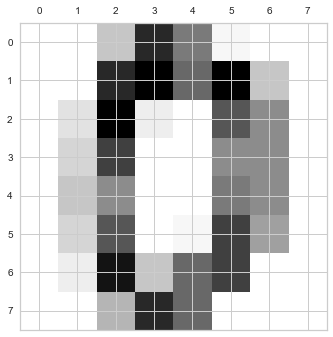

In [94]:
plt.matshow(digits.images[0]) 

So right here we see (albeit with a very low resolution), how image objects are stored: as an array, as a target label, and a visualisation, all for the number 0 in the images dataset. 

Usually, images we deal with in the real world and with modern day deep learning have a lot more information, but they tend to follow similar representations.

#### Images as colors in space

What we just saw was a very basic way of representing an image, with a location and a singular value for color. The matrix representation which we see there has only one channel to describe color. Normally, for computers, we use three channels: red, green and blue, and often images are in RGB format. This means all images can be thought of as a three dimensional tensors where we have 2D pixel location and its 3D (RGB) color information (or, similarly, a 2D pixel location and a 3-attribute color feature).

We'll now see some images in rgb (and other) formats with scikit-image.

#### scikit-image

https://scikit-image.org/

Scikit-image is a popular image processing dataset which is often used for a lot of standad image related tasks as well as machine learning tasks. Let's quickly look at the kinds of things we can do with it.

In [95]:
from skimage.io import imshow, imsave, imread
from skimage import data

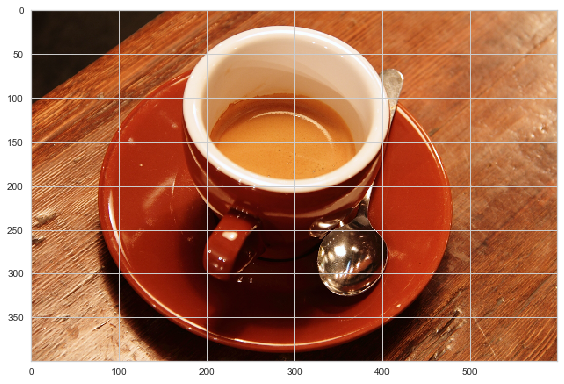

In [96]:
image = data.coffee()
imshow(image)

In [97]:
image.shape

(400, 600, 3)

In [98]:
image[0]

array([[ 21,  13,   8],
       [ 21,  13,   9],
       [ 20,  11,   8],
       ...,
       [228, 182, 138],
       [231, 185, 142],
       [228, 184, 140]], dtype=uint8)

In [99]:
from skimage.transform import rotate

In [100]:
image_90 = rotate(image, angle=90)

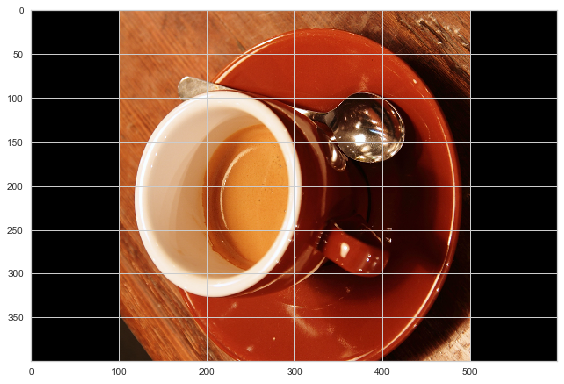

In [101]:
imshow(image_90)

In [102]:
image_90.shape

(400, 600, 3)

In [103]:
from skimage.transform import rescale

In [104]:
image_rescaled = rescale(image, 0.25, anti_aliasing=False).squeeze()

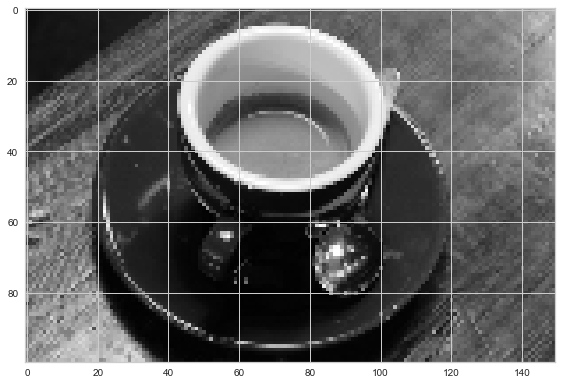

In [105]:
imshow(image_rescaled)

In [106]:
imsave("coffee.png", image)

This was some basic playing around... scikit image offers us a lot more as well. 

### Alternate representations of Images with non-standard Color Spaces

So now we've seen how images are represented with RGB as format. This isn't the only way to represent images though: [HSV](https://en.wikipedia.org/wiki/HSL_and_HSV) (hue, saturation, value) is another popular format for representing images, and for a representation scaled to human perception of color, the [JzAzBz](https://www.osapublishing.org/DirectPDFAccess/6CFCBC14-A874-4A54-86E948638765FA23_368272/oe-25-13-15131.pdf?da=1&id=368272&seq=0&mobile=no) representation has proved effective. We will see both in this section.

In [107]:
from skimage.color import rgb2hsv

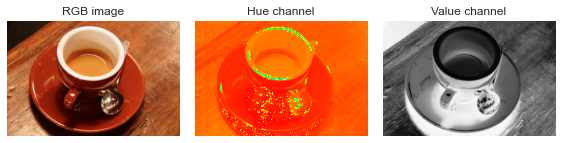

In [108]:
# code adapted from the scikit-image documentation: 
# https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_hsv.html

hsv_img = rgb2hsv(image)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(image)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

In [109]:
hsv_img

array([[[0.06410256, 0.61904762, 0.08235294],
        [0.05555556, 0.57142857, 0.08235294],
        [0.04166667, 0.6       , 0.07843137],
        ...,
        [0.08148148, 0.39473684, 0.89411765],
        [0.08052434, 0.38528139, 0.90588235],
        [0.08333333, 0.38596491, 0.89411765]],

       [[0.07142857, 0.66666667, 0.08235294],
        [0.05555556, 0.57142857, 0.08235294],
        [0.08974359, 0.65      , 0.07843137],
        ...,
        [0.08333333, 0.40350877, 0.89411765],
        [0.08333333, 0.3982684 , 0.90588235],
        [0.08333333, 0.40174672, 0.89803922]],

       [[0.08333333, 0.66666667, 0.08235294],
        [0.03846154, 0.56521739, 0.09019608],
        [0.07575758, 0.55      , 0.07843137],
        ...,
        [0.08333333, 0.40350877, 0.89411765],
        [0.08608059, 0.39912281, 0.89411765],
        [0.08608059, 0.39737991, 0.89803922]],

       ...,

       [[0.06994048, 0.59259259, 0.74117647],
        [0.07301587, 0.49065421, 0.83921569],
        [0.07044674, 0

In [110]:
image.shape

(400, 600, 3)

In [111]:
hsv_img.shape

(400, 600, 3)

Ok, so let's unpack some of that - images can be represented as 4D tensors/matrices, which explains those shapes - 400x600 is the total pixels, and then we have a value for each of these pixels. RGB stores the color channels, and HSV the representation models the way different paints mix together to create colour in the real world. While these representations are useful for computers to process images, they are not necessarily the best for capturing a perceptually uniform color space. The work by [Safdar et al 2017](https://www.osapublishing.org/DirectPDFAccess/6CFCBC14-A874-4A54-86E948638765FA23_368272/oe-25-13-15131.pdf?da=1&id=368272&seq=0&mobile=no) attempts to create such a color space (also called a "gamut") which is best suited to tasks which human beings attempt to do when they perceive images, such as differentiate between lightness and shades. Such a representation of image may be specifically suited to certain tasks involving images. The authors call this representation space a $J_zA_zB_z$ space, where $J_z$ represents lightness, $A_z$ represents redness-greenness, and $B_z$ represents yellowness-blueness.

We will now use the [comp-syn](https://github.com/comp-syn/comp-syn/) package that creates word - color embeddings using their $J_zA_zB_z$  functionality. comp-syn is a package that allows for multi-modal representations of words when viewed as their "average" representation via a collection of images associated with the word. By linking words to images either via image datasets or google images, we begin to form an idea of what the image representation of different words look like. The comp-syn package allows you to create representations of images in multiple formats which lend themselves to be useful when modelling these representations. 

While we will be exploring this multi-modal aspect of aligning words and images in the following notebook, in this notebook we will use their functionality to convert images into their JzAzBz representation.

To use comp-syn, we must first download the JzAzBz numpy array [google drive link](https://drive.google.com/file/d/1wspjIBzzvO-ZQbiQs3jgN4UETMxTVD2c/view?usp=sharing), install the package, and run the code. If you are having difficulties setting it up, you may skip this section.

In [112]:
!pip install compsyn --user

In [113]:
from compsyn.datahelper import rgb_array_to_jzazbz_array

In [114]:
jzazbz_image = rgb_array_to_jzazbz_array(image)

In [115]:
jzazbz_image

array([[[0.01127007, 0.00407485, 0.00660406],
        [0.01133101, 0.0041947 , 0.0057689 ],
        [0.01046174, 0.00483906, 0.00530166],
        ...,
        [0.12830229, 0.01663288, 0.04327499],
        [0.13023576, 0.01664737, 0.04233502],
        [0.12908856, 0.0156342 , 0.04262487]],

       [[0.01120888, 0.00394474, 0.00746844],
        [0.01133101, 0.0041947 , 0.0057689 ],
        [0.01129628, 0.00262845, 0.00763482],
        ...,
        [0.12819012, 0.01638742, 0.0446668 ],
        [0.13006587, 0.01628265, 0.04441847],
        [0.12881571, 0.01635235, 0.04458392]],

       [[0.01151412, 0.00323853, 0.00795241],
        [0.01184759, 0.00554325, 0.00565606],
        [0.01141756, 0.00288751, 0.00594444],
        ...,
        [0.12819012, 0.01638742, 0.0446668 ],
        [0.12891954, 0.01526579, 0.04470997],
        [0.12954505, 0.01523332, 0.04462755]],

       ...,

       [[0.09642082, 0.02849753, 0.05525978],
        [0.11442146, 0.02376162, 0.05029509],
        [0.1050618 , 0

In [116]:
jzazbz_image.shape

(400, 600, 3)

Ok, so we see now we have an image representation with the same shape as RGB and HSV, but with different values - each pixel has a $J_z$, $A_z$, and $B_z$ value. So how can this representation be used? In terms of your Machine Learning pipelines, it is possible to simply represent images in $J_zA_zB_z$ instead of RGB for classification or segmentation tasks. There is currently research underway exploring how color spaces effect the way classification occurs ([Gowda and Yuan, 2019](https://arxiv.org/pdf/1902.00267.pdf)), and early work suggest that choosing the right color space can significantly improve results. Work remains to be done to study which color spaces might be best for which task and setting.

### Binning Images

In the work by [Guilbeault et al, 2020](https://www.sciencedirect.com/science/article/abs/pii/S0010027720301256), they use the $J_zA_zB_z$ color space to see how abstract concepts are represented in the color space. Instead of measuring pixel by pixel, they use a  they use a histogram binning as a method to create a dense representation of the color space distribution. The code below allows you to unravel an image, and based on how many bins we want, represent the color distributions in those bins.

In [117]:
# the default max and min values are for JzAzBz
# the max Hue value is 360
# the max R/G/B value is 255
def binning_image(image, 
        spacing=36,
        num_bins=8,
        num_channels=3,
        dim_0_min=0.0,
        dim_0_max=0.167,
        dim_1_min=-0.1,
        dim_1_max=0.11,
        dim_2_min=-0.156,
        dim_2_max=0.115,
        h_max=360,
        rgb_max=255,
        dims=(300, 300)):
    
    dist = np.ravel(
                        np.histogramdd(
                            np.reshape(
                                image[:, :, :], (dims[0] * dims[1], num_channels)
                            ),
                            bins=(
                                np.linspace(
                                    dim_0_min,
                                    dim_0_max,
                                    1 + int(num_bins ** (1.0 / num_channels)),
                                ),
                                np.linspace(
                                    dim_1_min,
                                    dim_1_max,
                                    1 + int(num_bins ** (1.0 / num_channels)),
                                ),
                                np.linspace(
                                    dim_2_min,
                                    dim_2_max,
                                    1 + int(num_bins ** (1.0 / num_channels)),
                                ),
                            ),
                            density=True,
                        )[0]
                    )
    return dist

In [118]:
binned_jzazbz_img = binning_image(jzazbz_image, dims=(400, 600))

In [119]:
binned_jzazbz_img

array([3.50737932e-03, 9.76454401e+00, 3.50737932e-03, 4.66979497e+02,
       2.10442759e-02, 2.43412124e+01, 4.91033104e-02, 3.40591083e+02])

Let us unpack this value - we have 8 dimensions, and this serves as a compression of the color distribution of an image, in this case in a $J_zA_zB_z$ color space. These vectors can be used a condensed representation of the colors and lighting in an image, and have been found to be useful when working in semantic spaces ([Guilbeault et al, 2020](https://www.sciencedirect.com/science/article/abs/pii/S0010027720301256), [Srinivasa Desikan et al, 2020](https://www.aclweb.org/anthology/2020.coling-main.154/)). The work also demonstrated that the clustering and classification analysis is insensitive to binning size. We will be digging deeper into these representations by measuring between them in the next tutorial.

## Images for Deep Learning

When we are using images for deep learning, there are a few standard pre-processing steps that must be done to images. When we are working with pre-trained models, we must be sure that our pre-processing matches how the images were pre-processed for the original training. 

Let us load a few sample datasets from pytorch and see what kind of options we have. For vision related tasks, we use torchvision: https://pytorch.org/docs/stable/torchvision/index.html

In [120]:
!pip install torchvision --user

In [121]:
import torch 
import torchvision
import torch.nn as nn

Each of the image pre-processing tasks are referred to as transformations. Some standard transformations are resizing, rescaling, and normalising the image with respect to the mean and standard deviation asssociated with the model. In PyTorch we use the transformer class to do these tasks, and can stack them up with the compose function.

https://pytorch.org/docs/stable/torchvision/transforms.html

Below is an example of transformations often applied to images. Here, this is part of a series of pre-processing steps for getting an image compatible with resnet-18, a popular Convolutional Neural Network used to train images.

In [122]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [123]:
from PIL import Image


In [124]:
image = Image.open('coffee.png')

In [125]:
transformed_image = transforms(image)

In [126]:
transformed_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


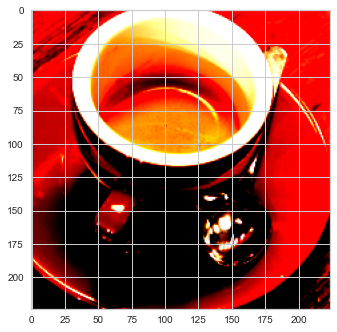

In [127]:
# the permute function to put the channels as the last dimensions
plt.imshow(transformed_image.permute(1, 2, 0))

These transformations are applied on each of the images for training and testing. As with text, for deep learning we don't often do a lot of pre-processing beyond resizing/rescaling and normalising the image. The deep learning does the processing itself!

### Vector Representations and Image Embeddings

So far we have seen how computers store images and represent them. How do neural networks interpret images after being fed them? How do images pass through a deep neural model. Luckily for us with pre-trained models, we can perform this rapidly. Here, we use the final pre-trained layer, which is the avgpool layer. We use different layers depending on the kind of model.

In [128]:
import torchvision.models as models


In [129]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
d = model.eval()

In [130]:
def get_vector(image):
    # code adapted from the package:
    # https://github.com/christiansafka/img2vec/
    # Create a PyTorch tensor with the transformed image
    t_img = transforms(image)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    with torch.no_grad():                               # <-- no_grad context
        model(t_img.unsqueeze(0))                       # <-- unsqueeze
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

In [131]:
get_vector(image)

tensor([5.2114e-01, 6.5401e-01, 7.8711e-01, 6.6875e-01, 5.4115e-01, 3.7802e-01,
        1.1054e+00, 1.6093e+00, 2.6552e-01, 5.7210e-01, 2.2767e+00, 4.4873e-01,
        2.2637e+00, 3.2761e+00, 3.2214e+00, 3.2748e-01, 1.8859e+00, 2.5248e-01,
        8.6163e-01, 2.1344e-01, 3.7674e-01, 5.2334e-01, 1.3600e-01, 4.0304e-01,
        1.2428e-01, 4.0099e-02, 2.5791e+00, 1.3981e+00, 2.9638e+00, 1.1057e-01,
        8.2059e-01, 1.0223e-01, 1.0537e-01, 2.8677e-02, 9.2865e-01, 3.3943e-01,
        1.6272e-02, 2.1651e+00, 7.4947e-02, 1.7024e+00, 3.1514e-01, 1.2285e+00,
        6.3144e-01, 4.7805e-01, 1.6355e-01, 1.6328e+00, 7.0304e-01, 1.5598e+00,
        0.0000e+00, 9.9328e-01, 4.1731e-01, 4.4468e-01, 6.5173e-01, 2.8210e-01,
        6.1957e-02, 3.5009e+00, 6.9768e-01, 6.5838e-01, 8.7600e-01, 4.3350e-01,
        9.6130e-01, 7.4099e-01, 9.6379e-01, 3.0546e+00, 2.1678e-03, 6.4732e-01,
        5.0525e-01, 2.0349e+00, 2.8286e-01, 1.8410e-01, 1.5675e+00, 2.0140e-01,
        3.2531e+00, 5.6871e-01, 1.7803e+

Cool! So we just passed our transformed coffee image to the pre-trained resnet model and got a 512 dimensional image vector as result. resent uses this vector to classify it. We can expect this image embedding to contain information of what are the coffee-like characteristics of an image. 

The same code is wrapped up in the package img2vec_pytorch, and so far features a quick vector creation pipeline for resnet and AlexNet.

In [132]:
!pip install img2vec_pytorch

In [133]:
from img2vec_pytorch import Img2Vec


In [134]:
img2vec = Img2Vec()

In [135]:
coffee_vec = img2vec.get_vec(image)

In [136]:
coffee_vec

array([2.25797206e-01, 2.81964779e-01, 4.98293132e-01, 6.94463015e-01,
       4.40986425e-01, 4.68564898e-01, 1.37138379e+00, 6.28250957e-01,
       3.25331479e-01, 4.40027677e-02, 2.58244085e+00, 8.19615602e-01,
       2.54137397e+00, 2.57595539e+00, 3.83238435e+00, 1.38657495e-01,
       2.97213197e-01, 1.29888451e+00, 2.88481146e-01, 7.08386973e-02,
       2.87005007e-01, 4.79841739e-01, 1.48024922e-02, 3.16166073e-01,
       8.72732550e-02, 1.39363527e-01, 3.53840661e+00, 5.03714025e-01,
       4.30884361e+00, 0.00000000e+00, 4.83361453e-01, 5.93673468e-01,
       4.40400481e-01, 1.37258410e-01, 1.12684894e+00, 6.74996614e-01,
       0.00000000e+00, 1.57064974e+00, 1.34779140e-02, 1.43884492e+00,
       2.78478324e-01, 1.73063087e+00, 8.70220602e-01, 8.43109846e-01,
       2.13631958e-01, 2.55658579e+00, 3.00220460e-01, 1.60575902e+00,
       8.52546766e-02, 1.10646105e+00, 1.66480139e-01, 1.09477139e+00,
       6.48421526e-01, 5.55999339e-01, 1.07370980e-01, 2.64314556e+00,
      

I uploaded my own pictures of a cat and dog, here. Feel free to do the same!

In [137]:
cat_image = Image.open("cat.png")

In [138]:
dog_image = Image.open("dog.png")

These vectors are useful because we can then perform basic similarity checks using them.

In [139]:
cat_vec = img2vec.get_vec(cat_image.convert('RGB'), tensor=True)

In [140]:
dog_vec = img2vec.get_vec(dog_image.convert('RGB'), tensor=True)

In [141]:
coffee_vec = img2vec.get_vec(image, tensor=True)

In [142]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [143]:
cos_sim = cos(cat_vec,
              dog_vec)

In [144]:
cos_sim

tensor([[[0.6046]]])

In [145]:
cos_sim = cos(coffee_vec,
              dog_vec)

In [146]:
cos_sim

tensor([[[0.4941]]])

Whew! The cat looks more like the dog than the coffee cup.

## Audio Data: Deep Learning

In this section we will look at how audio files are structured and how to extract features from them. We will start with some installations and imports.



In [147]:
!pip install pysoundfile

In [148]:
!pip install speechrecognition

In [149]:
!pip install pydub

In [150]:
#these three do audio handling
import pydub #Requires ffmpeg to be installed https://www.ffmpeg.org/download.html; on a mac "brew install ffmpeg"
import speech_recognition #install as speechrecognition
import soundfile #Install as pysoundfile 

In [151]:
import os

Audio (and video) files come in two major categories, lossy or lossless. Lossless files save all information the microphone recorded. Lossy files, by contrast, drop sections humans are unlikely to notice. Recorded frequencies for both types are then typically compressed, which introduces further loss. To work with audio files, we want a format that is preferably lossless or minimally compressed. We will work with wav files here. Note that mp3 is not acceptable. If you do not have wav files, we can use python to convert to wav.

NOTE: please visit [this GitHub link](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/tree/main/data/audio_samples) and download the files which we will work with.

In [152]:
samplePath = 'content/SBC060.mp3'
transcriptPath = 'SBC060.trn'

In [153]:
# We are using a different package to convert than the in the rest of the code
def convertToWAV(sourceFile, outputFile, overwrite = False):
    if os.path.isfile(outputFile) and not overwrite:
        print("{} exists already".format(outputFile))
        return
    #Naive format extraction
    sourceFormat = sourceFile.split('.')[-1]
    sound = pydub.AudioSegment.from_file(sourceFile, format=sourceFormat)
    sound.export(outputFile, format="wav")
    print("{} created".format(outputFile))
wavPath = 'sample.wav'
convertToWAV(samplePath, wavPath)

sample.wav exists already


Now that we have created our wav file, notice that it is much larger than the source mp3. We can load it with soundfile and work with it as a numpy data array.



In [154]:
soundArr, soundSampleRate = soundfile.read(wavPath)
soundArr.shape

(65705472, 2)

This is the raw data as a column array, which contains two channels (Left and Right) of the recording device. Some files, of course, will have more columns (from more microphones). The array comprises a series of numbers that measure the location of the speaker membrane (0=resting location). By quickly and rhythmically changing the location a note can be achieved. The larger the variation from the center, the louder the sound; the faster the oscillations, the higher the pitch. (The center of the oscillations does not have to be 0).



In [155]:
soundSampleRate


44100

In [156]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The sample is 1489 seconds long
Or 24.82 minutes


The final critical parameter of sound digitization is quantisation, which consists in assigning a value to each sample according to its amplitude. These values are attributed according to a bit scale. A quantisation of 8 bit will assign amplitude values along a scale of $2^8 = 256$ states around 0. Most recording systems use a $2^{16} = 65536$ bit system. Quantisation is a rounding process, where high bit quantisation produces values close to reality with values rounded to a high number of significant digits, and low bit quantisation produces values further from reality with values rounded a low number of significants digits. Low quantisation can lead to impaired quality signal.

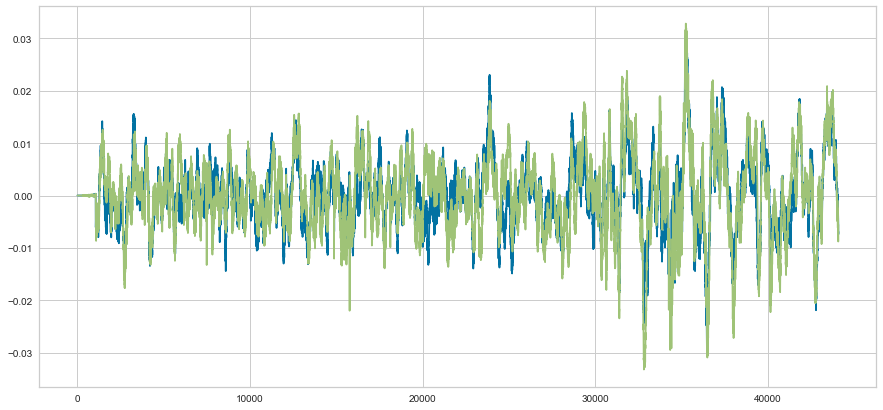

In [157]:

fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate])
plt.show()

We get 2 (Left and Right) nearly "flat" (or equally wavy) lines. This means that there is very little noise at this part of the recording. What variation exists is due to compression or interference and represents the slight hiss you sometimes hear in low quality recordings.

Let's expand our scope and look at the first 10 seconds:

In [158]:
soundArr.shape


(65705472, 2)

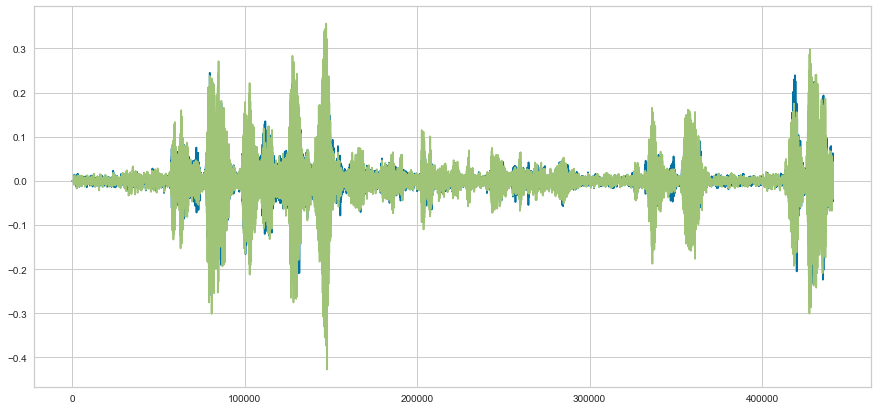

In [159]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate * 10])
plt.show()


Now we can see definite spikes, where each represents a word or discrete sound.

To see what the different parts correspond to, we can use a transcript. Because we got this file from the [Santa Barbara Corpus of Spoken American English](https://www.linguistics.ucsb.edu/research/santa-barbara-corpus#Contents), we just need to load the metadata, which includes a transcription.

In [160]:
import re
import pandas

In [161]:
def loadTranscript(targetFile):
    #Regex because the transcripts aren't consistent enough to use csv
    regex = re.compile(r"(\d+\.\d+)\s(\d+\.\d+)\s(.+:)?\s+(.*)")
    dfDict = {
        'time_start' : [],
        'time_end' : [],
        'speaker' : [],
        'text' : [],
    }
    with open(targetFile, encoding='latin-1') as f:
        for line in f:
            r = re.match(regex, line)
            dfDict['time_start'].append(float(r.group(1)))
            dfDict['time_end'].append(float(r.group(2)))
            if r.group(3) is None:
                dfDict['speaker'].append(dfDict['speaker'][-1])
            else:
                dfDict['speaker'].append(r.group(3))
            dfDict['text'].append(r.group(4))
    return pandas.DataFrame(dfDict)

transcriptDF = loadTranscript(transcriptPath)
transcriptDF[:10]

,time_start,time_end,speaker,text
0,0.000,2.572,ALAN:,"... (H) I got a story to tell you,"
1,2.572,3.820,ALAN:,"it's a shaggy dog story,"
2,3.820,6.645,ALAN:,but as long as were talking about that record...
3,6.645,8.378,ALAN:,"(H)= Ill tell you the story,"
4,8.378,10.178,ALAN:,"(H)= oh gosh,"
5,10.178,10.678,ALAN:,"uh (Hx),"
6,10.678,12.335,ALAN:,"Rae and I and Sue and Buddy,"
7,12.335,14.727,ALAN:,"... took a trip,"
8,14.727,17.012,ALAN:,"... to Mexico City,"
9,17.012,18.761,JON:,... (SNIFF)


Now let's look at a few sub-sections. First, to make things easier, we will convert the seconds markers to sample indices:


In [162]:
#Need to be ints for indexing, luckily being off by a couple indices doesn't matter
transcriptDF['index_start'] = (transcriptDF['time_start'] * soundSampleRate).astype('int')
transcriptDF['index_end'] = (transcriptDF['time_end'] * soundSampleRate).astype('int')

In [163]:
soundArr[transcriptDF['index_start'][6]: transcriptDF['index_end'][6]]

array([[-2.74658203e-04, -3.41796875e-03],
       [-9.15527344e-05, -2.86865234e-03],
       [ 1.52587891e-04, -2.59399414e-03],
       ...,
       [ 2.53295898e-03, -1.41296387e-02],
       [ 1.34277344e-03, -1.41296387e-02],
       [ 2.44140625e-04, -1.37329102e-02]])

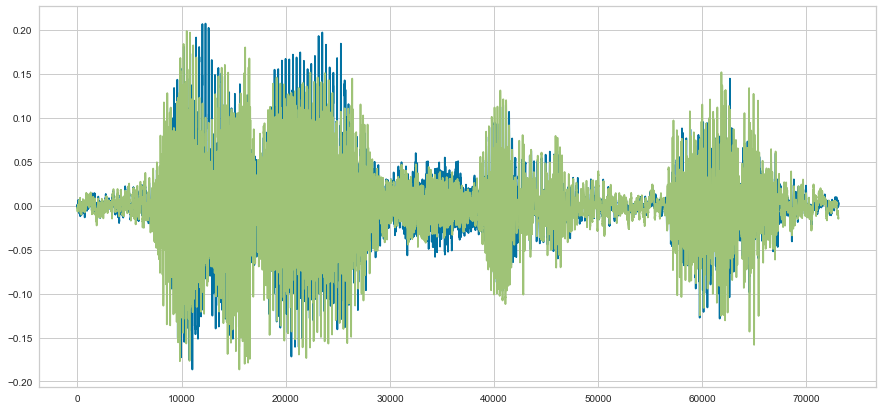

In [164]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample1 = soundArr[transcriptDF['index_start'][6]: transcriptDF['index_end'][6]]
ax.plot(subSample1)
plt.show()

In [165]:
# to write the file, if you want to listen to it
soundfile.write('content/sample1.wav', subSample1, soundSampleRate)


In order to see sounds in the frequency space, we can take the Fourier transform. This is a reversible mathematical transform named after the French mathematician Joseph Fourier (1768-1830). The transform decomposes a time series into a sum of finite series of sine or cosine functions.


In [166]:
import scipy.fftpack

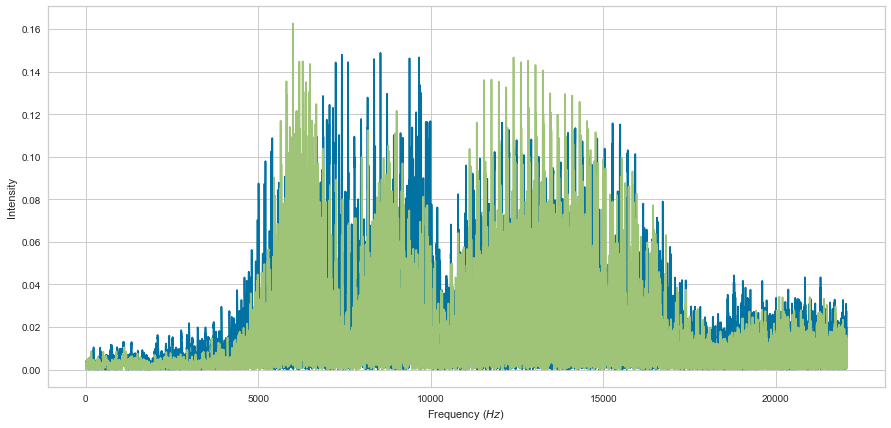

In [167]:
sample1FFT = scipy.fftpack.ifft(subSample1)
N = len(sample1FFT)
freq = scipy.fftpack.fftfreq(N, d = 1.0 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
ax.plot(freq[:N//2], abs(sample1FFT)[:N//2]) #Only want positive frequencies
plt.show()

This shows that there are two frequencies to the 'Rae and I and Sue and Buddy' snippet: a higher pitched 'Rae and I...Sue...Buddy' (~14000 Hz) and the final two 'and's (one at ~6000 Hz and the second at ~8000 Hz).

What does a sniff look like?



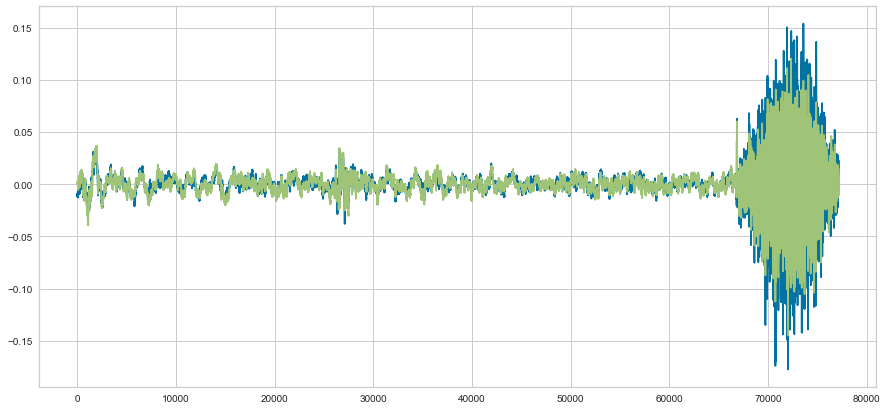

In [168]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample2 = soundArr[transcriptDF['index_start'][9]: transcriptDF['index_end'][9]]
ax.plot(subSample2)
plt.show()

Very different from speech. And now let's see what that sounds like:



In [169]:
import IPython
IPython.display.Audio('content/sample2.wav')

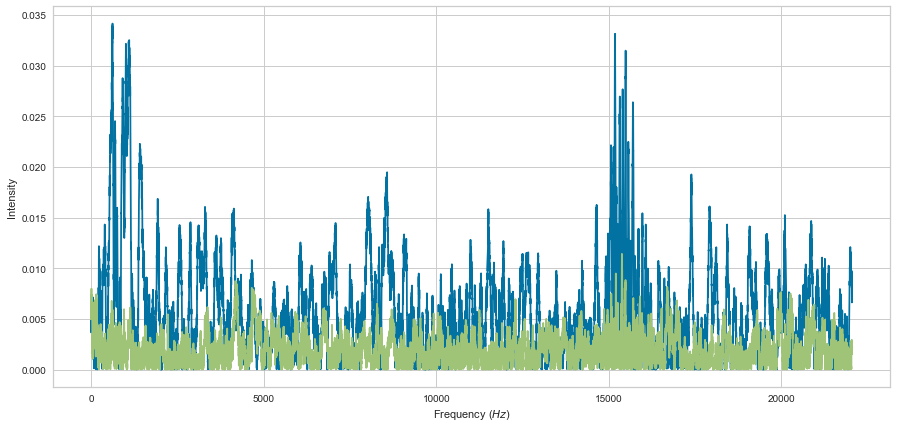

In [170]:
sample2FFT = scipy.fftpack.ifft(subSample2)
N = len(sample2FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(freq[:N//2], abs(sample2FFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

Notice how there is not a dominant frequency for the sniff as there was for the noun phrase earlier. This means that the sniff activated noise all across the frequency spectrum.

We can also investigate dominant frequencies for the entire record:

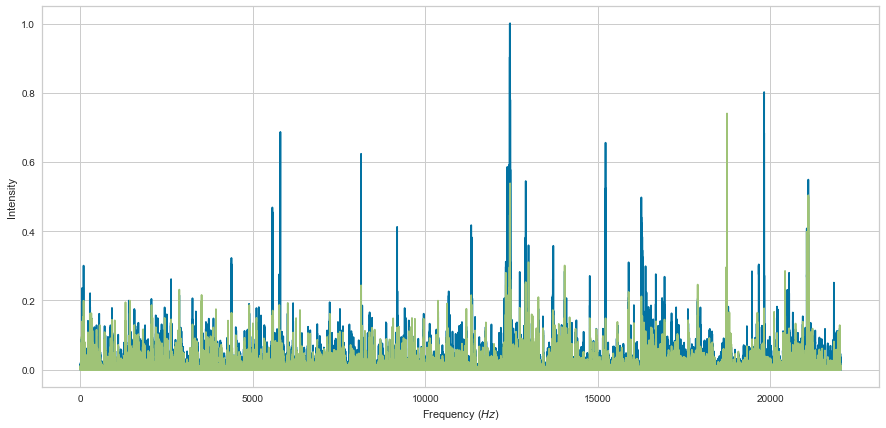

In [171]:
#This takes a while
fig, ax = plt.subplots(figsize = (15, 7))
fullFFT = scipy.fftpack.ifft(soundArr)
N = len(fullFFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
ax.plot(freq[:N//2], abs(fullFFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()


In [172]:
freq[len(freq) // 2 -10: len(freq) // 2 + 5]


array([ 22049.99328823,  22049.99395941,  22049.99463058,  22049.99530176,
        22049.99597294,  22049.99664412,  22049.99731529,  22049.99798647,
        22049.99865765,  22049.99932882, -22050.        , -22049.99932882,
       -22049.99865765, -22049.99798647, -22049.99731529])

Here we capture each person's frequencies across their entire collection of statements:



In [173]:
def maxfreq(sample, topN = 10):
    sampleFFT = scipy.fftpack.ifft(sample)
    N = len(sample)
    freqs = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
    tops =  np.argpartition(abs(sampleFFT[:, 0]), -topN)[-topN:]

    return np.mean(tops) 

freqs = []
for i, row in transcriptDF.iterrows():
    freqs.append(maxfreq(soundArr[row['index_start']: row['index_end']]))

transcriptDF['frequency FFT'] = freqs


Alan's speech exhibits the following frequencies:



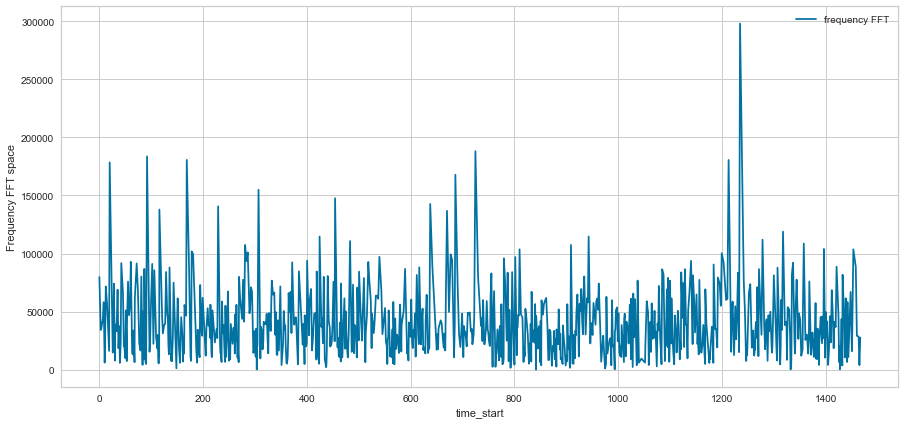

In [174]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'ALAN:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()


...while Jon's voice is **much** lower:



In [175]:
transcriptDF[transcriptDF['speaker'] == 'JON:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

Or we can look at them togther



In [176]:
import seaborn

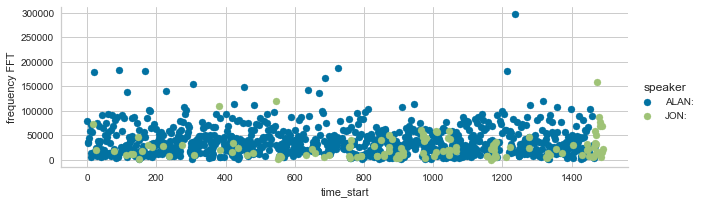

In [177]:

fg = seaborn.FacetGrid(data=transcriptDF, hue='speaker', aspect = 3)
fg.map(plt.scatter, 'time_start', 'frequency FFT').add_legend()



Today, most state of the art methods involving audio use deep learning methods to embed audio in a high dimensional space - similar to some of the methods we have seen before for text. While earlier methods for speech feature extraction and classification used audio features such as frequencies, as well as power (via the [Mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) coefficients), the success of word2vec quickly inspired [speech2vec](https://arxiv.org/pdf/1803.08976.pdf) method to use these features to construct semantically coherent vectors. This was a jump from the acoustic and phenome based vectors previously computed. Further work has lead to state-of-the-art wav2vec2, which we will explore in this section. We will be using the popular Transformers model (we will use this package in more detail in later chapters!), using them to load pre-trained wav2vec2 models for both creating a vector representation to making a transcription. In the example below we use a sample from librispeech, which is also what this model was trained on.

In [178]:
!pip install transformers

In [179]:
!pip install datasets

     -------------------------------------- 325.5/325.5 KB 5.1 MB/s eta 0:00:00
     --------------------------------------- 16.1/16.1 MB 14.3 MB/s eta 0:00:00
     -------------------------------------- 128.7/128.7 KB 7.9 MB/s eta 0:00:00
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
     ------------------------------------- 554.9/554.9 KB 17.6 MB/s eta 0:00:00
     -------------------------------------- 122.1/122.1 KB 7.0 MB/s eta 0:00:00


In [180]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2Model
from datasets import load_dataset
import soundfile as sf

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.


Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [181]:
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

In [182]:
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to C:\Users\parth\.cache\huggingface\datasets\patrickvonplaten___librispeech_asr\clean\2.1.0\f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc. Subsequent calls will reuse this data.


In [183]:
ds = ds.map(map_to_array)
input_values = tokenizer(ds["speech"][0], return_tensors="pt").input_values  # Batch size 1
hidden_states = model(input_values).last_hidden_state

  0%|          | 0/73 [00:00<?, ?ex/s]

In [184]:
hidden_states

tensor([[[-0.0032, -0.0086,  0.0228,  ..., -0.1943,  0.0403, -0.1071],
         [ 0.0021, -0.0078,  0.0205,  ..., -0.2157,  0.0311, -0.1106],
         [-0.0056, -0.0330,  0.0698,  ..., -0.2463, -0.0076, -0.1500],
         ...,
         [-0.0060, -0.0336,  0.0704,  ..., -0.2466, -0.0082, -0.1501],
         [-0.0013, -0.0162,  0.0132,  ..., -0.1883,  0.0449, -0.0850],
         [-0.0029, -0.0174,  0.0128,  ..., -0.1893,  0.0441, -0.0821]]],
       grad_fn=<NativeLayerNormBackward>)

The hidden state of the model serves as the embedding for the file. We will be digging deeper into using this embedding for similarity measures in the next notebook. Apart from measuring between audio files, these embeddings can be used for other ML tasks such as clustering or classification. We will now see how we can use this package for speech to text.

In [185]:
from transformers import Wav2Vec2ForCTC

In [186]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [187]:
logits = model(input_values).logits

In [188]:
predicted_ids = torch.argmax(logits, dim=-1)

In [189]:
transcription = tokenizer.decode(predicted_ids[0])

In [190]:
transcription

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

We see that with pre-trained deep learning models we can extract powerful representations of data. We will be going into more detail about this on our chapter on audio, image and video representations. We will also be measuring between audio representations in the next tutorial.

(For those interested in non-deep learning methods for extracting features and representing audio (speech, music, sound), you may want to consider: [package -> python-speech-features](https://python-speech-features.readthedocs.io/en/latest/); [blog post with the package -> Livrosa](https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d)

Surfboard is a package which is used specificially for audio feature extraction for modern machine learning: [github](https://github.com/novoic/surfboard); [arxiv paper -> Surfboard: Audio Feature Extraction for Modern Machine Learning](https://arxiv.org/pdf/2005.08848.pdf);[blog post](https://pythonawesome.com/a-python-package-for-modern-audio-feature-extraction/))

The next section is our final one on representations of data, and we will be exploring networks, graphs, and tables of structured data.

## Network Data

This section walks us through dealing with different kinds of network data and how to create representations of them which we can later use for ML and DL algorithms. We will also walk through some basic analysis we can do on networks and statistics we can pass to different models. 

In [191]:
import numpy as np
import networkx as nx

We mentioned that graphs are a way to represent connections between entities. From a mathematical perspective, this can be a set, one with information of the entities and the other with information on the edges (connections). It can also be a matrix or table, where each node is both a row and column, and the intersection of row, column indicates a connection between the two entities. Luckily, both of these are easy to translate into a computational perspective. Let's try it out.

In [192]:
G = nx.Graph()

So now we have an empty graph object. In networkx we can add nodes and edges easily, and also convert this into a numpy matrix representation.

In [193]:
# adding one at a time
G.add_node(1)

In [194]:
# adding a list 
G.add_nodes_from([2, 4])

In [195]:
G.nodes()

NodeView((1, 2, 4))

In [196]:
# we can add edges / connection
G.add_edge(1, 2)

In [197]:
# list of edges
G.add_edges_from([(1, 4), (2, 4)])

In [198]:
G.edges()

EdgeView([(1, 2), (1, 4), (2, 4)])

In [199]:
G[1][2]['weight'] = 2

In [200]:
nx.to_numpy_matrix(G)

matrix([[0., 2., 1.],
        [2., 0., 1.],
        [1., 1., 0.]])

So we see how each of the nodes here are one a column, and the values in the matrix represent the weights. Networkx also lets us draw the matrix.

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt

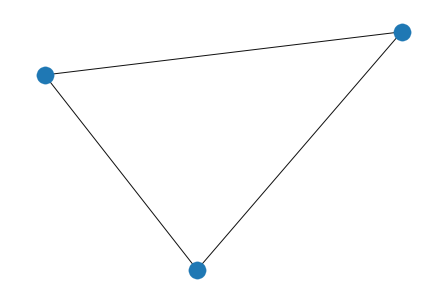

In [202]:
nx.draw(G)

Networkx also lets you convert graphs to and from pandas, numpy, lists, dictionaries.. and so on. We highly recommend you check out for a full list of the functions which help you do this converting: https://networkx.org/documentation/stable//reference/convert.html

This means we can manipulate graphs in many ways and in different data formats. 
Another way to play with graphs is generate graphs from random processes, or load graphs which are already created by others. Let's check both out!

In [203]:
random_graph = nx.fast_gnp_random_graph(n=15, p=0.5)

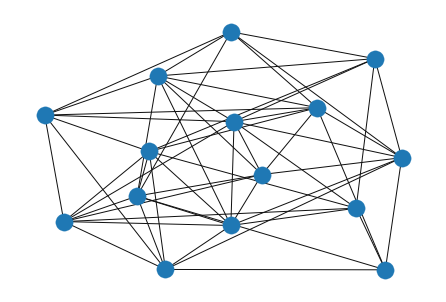

In [204]:
nx.draw(random_graph)

There are also a couple of popular, small networks which are created through different kinds of data collection - in this case, it is an anthropological study. 

Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473.

In [205]:
karate_club_graph = nx.karate_club_graph()

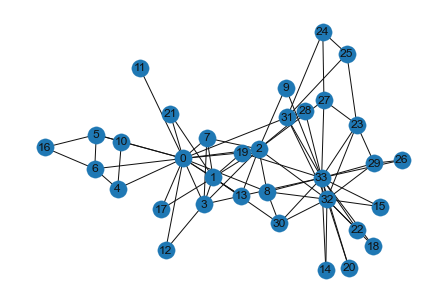

In [206]:
nx.draw(karate_club_graph, with_labels=True)

In [207]:
nx.to_numpy_matrix(karate_club_graph)

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

Some common tasks involving networks includes link prediction and node classification. For these kinds of tasks, certain network features are useful. Networkx has a full suite of network related algorithms: https://networkx.org/documentation/stable/reference/algorithms/index.html

Let's see one such example with degree centrality, which is a measure of how central different nodes are as a function of the number of edges associated with it.

In [208]:
nx.degree_centrality(karate_club_graph)

{0: 0.48484848484848486,
 1: 0.2727272727272727,
 2: 0.30303030303030304,
 3: 0.18181818181818182,
 4: 0.09090909090909091,
 5: 0.12121212121212122,
 6: 0.12121212121212122,
 7: 0.12121212121212122,
 8: 0.15151515151515152,
 9: 0.06060606060606061,
 10: 0.09090909090909091,
 11: 0.030303030303030304,
 12: 0.06060606060606061,
 13: 0.15151515151515152,
 14: 0.06060606060606061,
 15: 0.06060606060606061,
 16: 0.06060606060606061,
 17: 0.06060606060606061,
 18: 0.06060606060606061,
 19: 0.09090909090909091,
 20: 0.06060606060606061,
 21: 0.06060606060606061,
 22: 0.06060606060606061,
 23: 0.15151515151515152,
 24: 0.09090909090909091,
 25: 0.09090909090909091,
 26: 0.06060606060606061,
 27: 0.12121212121212122,
 28: 0.09090909090909091,
 29: 0.12121212121212122,
 30: 0.12121212121212122,
 31: 0.18181818181818182,
 32: 0.36363636363636365,
 33: 0.5151515151515151}

Network science is a vast field deeply linked (pun intended) with data science. While we'll look at deep learning for graphs and tables in more detail on the dedicated chapter to it, let's whip up a few basic graph-based embeddings to see what they say!

In [209]:
!pip install node2vec

In [210]:
from node2vec import Node2Vec

In [211]:
node2vec = Node2Vec(karate_club_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

In [212]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [213]:
model.wv.get_vector('0')

array([ 0.1885472 , -0.03881061,  0.11775811,  0.02198458, -0.05724266,
       -0.08111065, -0.03483089,  0.17062847,  0.18903635, -0.23388146,
        0.04062673, -0.09154786,  0.12827367,  0.25473195, -0.07851547,
       -0.0057428 , -0.24153854,  0.04381931, -0.13535844,  0.19613788,
        0.23133852,  0.0558586 ,  0.22392595, -0.04908618, -0.09634457,
        0.13428941, -0.16141984, -0.14910658, -0.01918806, -0.10400271,
        0.00193517, -0.00082033,  0.02319744, -0.16556004,  0.02836511,
        0.18736778,  0.06643529,  0.09625254,  0.11094055,  0.27396333,
        0.09308173, -0.04204471,  0.02309555, -0.0110543 , -0.17979491,
       -0.08721015, -0.01242984, -0.1881475 ,  0.00433414, -0.00573624,
       -0.09749098,  0.2345507 ,  0.12832406,  0.07982208,  0.03492706,
        0.37987745,  0.30625552, -0.09487209, -0.00255057, -0.19003664,
        0.1053436 ,  0.00931699, -0.16942844,  0.12443944], dtype=float32)

In [214]:
model.wv.most_similar('0')

[('4', 0.7617543339729309),
 ('10', 0.7592153549194336),
 ('17', 0.7549446225166321),
 ('21', 0.7467179298400879),
 ('7', 0.7008758783340454),
 ('11', 0.6688173413276672),
 ('5', 0.6644293069839478),
 ('6', 0.6530205607414246),
 ('19', 0.6508572697639465),
 ('1', 0.6508012413978577)]

In [215]:
model.wv.most_similar('33')

[('32', 0.8440507650375366),
 ('18', 0.8335971236228943),
 ('14', 0.8239652514457703),
 ('29', 0.8179886341094971),
 ('15', 0.7429625391960144),
 ('22', 0.7364576458930969),
 ('20', 0.7251341342926025),
 ('23', 0.68465256690979),
 ('26', 0.6828494668006897),
 ('8', 0.6560297012329102)]

Take some time to interpret the closest nodes based on the node2vec embedding  - what aspect of similarity is best captured? 

the node2vec package also includes edge embeddings, via the Hadamard Embedder.

In [216]:
from node2vec.edges import HadamardEmbedder

In [217]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [218]:
edges_embs[('24', '25')]

array([ 6.32037548e-03, -5.22977207e-03,  4.82183248e-02,  7.18155280e-02,
       -2.86631193e-03,  1.29826413e-02,  3.65741877e-03,  1.98131859e-01,
        1.33757330e-02,  9.79457609e-03, -2.42003216e-03,  8.43380112e-05,
        1.56096555e-03,  1.17682363e-03,  6.84609190e-02,  8.81536026e-03,
        2.46808063e-02, -4.87960083e-03,  3.58905047e-02,  3.52932028e-02,
        8.91577266e-03,  5.72818739e-04,  7.03813657e-02, -1.25450338e-03,
        2.38367729e-03,  6.36801496e-02,  2.05711219e-02, -8.23954178e-04,
        1.12050235e-01,  4.58506793e-02,  3.56019437e-02, -5.80303138e-03,
        2.48767957e-01,  1.19036883e-01,  8.02662969e-02,  1.07762264e-02,
        2.15591383e-04,  1.31284958e-02,  1.11643016e-01,  1.02255028e-02,
        1.13750137e-01,  1.75249856e-02, -3.14322184e-03,  7.36234104e-03,
        1.10876821e-02,  7.76460860e-03,  7.96096213e-03,  4.32156473e-02,
        5.74700488e-03,  1.97164237e-01,  6.81368588e-03,  7.89031908e-02,
       -1.24080363e-03,  

In [219]:
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████| 595/595.0 [00:00<00:00, 198300.43it/s]


In [220]:
edges_kv.most_similar(str(('24', '25')))

[("('25', '25')", 0.9427266120910645),
 ("('24', '24')", 0.9410122632980347),
 ("('23', '25')", 0.9086276888847351),
 ("('24', '27')", 0.9036458134651184),
 ("('23', '24')", 0.8925583958625793),
 ("('24', '31')", 0.8887876272201538),
 ("('25', '31')", 0.8753666281700134),
 ("('25', '27')", 0.8399688005447388),
 ("('25', '28')", 0.8266949653625488),
 ("('24', '28')", 0.817001461982727)]

These node and edge embeddings can be used for a wide range of other downstream tasks. node2vec serves as a useful way to quickly prototype these alternate approaches to representing a network or graph. It's also possible to embed an entire graph, and then we can measure between two different graphs. Graph Neural Network models also help you perform a series of tasks on graphs such as community detection and link prediction. We'll be seeing this in more detail in later chapters, but hopefully this gave you an idea on the different graph representations out there!

Finally, we can turn tables into representations. These have become most popular in the context of collaborative filtering, where a sparse table of associations between persons and products/songs/movies is embedded, which discovers associations between persons (rows) and elements (columns) for preference prediction. Dense tables can also be embedded to facilitate information search. Consider the table2vec approach: https://arxiv.org/abs/1906.00041

# <span style="color:red">*Homework Exercise*</span>

In this notebook we have seen how different kinds of data are often represented. The purpose of this homework is to get used to dealing with different vectorisation / tensorisation / embedding / representations for these different kinds of data. Perform the tasks requested below each of the associated questions.

**1)** Find and load a *textual* dataset and create 3 different representations of this data. You can use any external source of pre-compiled text data (such as Kaggle), or put together your own dataset.



***1b)*** How does each representation structure the data differently (e.g., the shape/dimension of the representation, range of values etc.) What implications does this hold for  

In [221]:
textrepresentations= 'something' #@param {type:"string"}

***1c)*** What is an alternative way that you could represent a document, beyond those we have discussed here? 

In [222]:
newtextrepresentations= 'something' #@param {type:"string"}

**2)** Find and load an *image* based dataset and create 2 different representations of this data. You can use any external source of pre-compiled text data (such as Kaggle), or put together your own dataset. 

***2b)*** How does each representation structure the data differently (e.g., the shape/dimension of the representation, range of values, etc.) 

In [58]:
imagerepresentations= 'something' #@param {type:"string"}


**3)** Find and load a *network or graph* based dataset and create 2 different representations of this data. You can use any external source of pre-compiled text data (such as Kaggle), or put together your own dataset.

***3b)*** How does each representation structure the data differently (e.g., the shape/dimension of the representation, range of values, etc.)?


In [59]:
netrepresentations= 'something' #@param {type:"string"}

**4)** Find and load an *audio* dataset and create 1 representation of this data. You can use any external source of pre-compiled text data (such as Kaggle), or put together your own dataset.

***4b)*** How does each representation structure the data differently (e.g., the shape/dimension of the representation, range of values, etc.)?

In [ ]:
audiorepresentations= 'something' #@param {type:"string"}

**5)** Research across disciplines strives to find representations of data that are powerful for a variety of tasks. In the section on audio data, we linked to multiple audio representations that don't use deep learning methods but can still extract useful representations. Either by using links we provided, or new links you find, create a representation of text, images, networks, tabular, or audio that has not been demonstrated in this notebook.

**6)** Dimensionality reduction tecniques such as PCA, tSNE, and UMAP help us visualise high dimensional representations. Use these methods on the representations of data you have created to see what structure is captured.

***6b)*** Interpret the structure captured in your representation?

In [ ]:
structure= 'something' #@param {type:"string"}

## ***Hint***
Here are reasonably sized datasets we load for you. You can use them for this homework, or follow the steps to load your own for use in the loading and representations tasks above.

In [ ]:
#@markdown How many hours did it take you to complete this homework?
hours = 1 #@param {type:"number"}

In [ ]:
#@markdown How hard was this homework?
too_easy_too_hard = 2.5 #@param {type:"slider", min:0, max:10, step:0.1}

